In [1]:
import numpy as np
import xarray as xr
import uxarray as uxr

from scripts import umeshFcts as ufcts

# Create a global mesh for goSPL

Create an unstructured grid for a given cell width. The method relies on the UXarray and jigsaw libraries.

**In case where the mesh already exists it will not be recreated.**

Spherical mesh resolution km

| cell_width | edge_min  | edge_max | edge_mean | nodeNb |
| ---------- | ----------  | ---------- | ---------- | ---------- |
| 5 | 1.1 | 4.5 | 2.8 | 23632811 |
| 8 |  1.8 | 7.2 | 4.6  | 9236387 | 
| 10 | 2.2 | 8.9 | 5.7 | 5912778 |
| 15 | 3.3 | 13.1 | 8.6 | 2629742 |
| 20 | 4.5 | 18 | 11.5 | 1480168 |
| 25 | 5.6 | 22.4 | 14.4 | 947701 |
| 30 | 6.8 | 26.4 | 17.2 | 658525 |
| 35 | 8 | 30.5 | 20.1 |  484009 |

In [ ]:
#ufcts.buildGlobalMeshSimple?

In [ ]:
widthCell = 30
input_path = "input_"+str(widthCell) 

# Build the mesh
ufcts.buildGlobalMeshSimple(widthCell, input_path)

## Map variables on the UGRID 

We will now map global variables on this unstructured grid. In goSPL, typical variables would be:

- elevation (in m)
- vertical and horizontal tectonic forcing (displacement rates in m/yr)
- precipitation (in m/yr)
- dynamic topography (in m/yr)

Usually they will be provided in the form of `netcdf` or `geotiff` files. In both cases, the `xarray` or `rioxarray` libraries will allow you to open those files conveniently.

> Here we will use a netcdf grid containing all of these variables (except dynamic topography) for a give time interval.

In [ ]:
# Loading the nc regular file
ncgrid = xr.open_dataset('data/250.nc')
ncgrid

In case the file contains more variables than the ones you need for goSPL, you can select only the necessary ones:

In [ ]:
ncgrid = ncgrid[['h','vx','vy','vz','rain']]
ncgrid

In [ ]:
# Loading the UGRID file
ufile = input_path+'/mesh_'+str(widthCell)+'km.nc'
ugrid = uxr.open_grid(ufile) 
# ugrid

# Perform the interpolation (bilinear) 
var_path = 'vars_'+str(widthCell)
var_name = 'step_250'
ufcts.inter2UGRID(ncgrid,ugrid,var_path,var_name,type='face')

In the `var_path` folder, you will find interpolated variables for the the UGRID (one file per variable) 

In [ ]:
data_file = [var_path+'/'+var_name+'.nc']

# Get the information related to the mesh: primal and dual mesh
primal_mesh = uxr.open_dataset(ufile, *data_file, use_dual=False)
dual_mesh = uxr.open_dataset(ufile, *data_file, use_dual=True)

# Extract nodes and faces information
ucoords = np.empty((dual_mesh.uxgrid.n_node,3))
ucoords[:,0] = dual_mesh.uxgrid.node_x.values
ucoords[:,1] = dual_mesh.uxgrid.node_y.values
ucoords[:,2] = dual_mesh.uxgrid.node_z.values
ufaces = primal_mesh.uxgrid.node_face_connectivity.values

# Get information about your mesh:
print("Number of nodes: ",len(ucoords)," | number of faces ",len(ufaces))
edge_min = np.round(dual_mesh.uxgrid.edge_node_distances.min().values/1000.+0.,2)
edge_max = np.round(dual_mesh.uxgrid.edge_node_distances.max().values/1000.+0.,2)
edge_mean = np.round(dual_mesh.uxgrid.edge_node_distances.mean().values/1000.+0.,2)
print("edge range (km): min ",edge_min," | max ",edge_max," | mean ",edge_mean)

In [ ]:
# Save voronoi mesh for visualisation purposes
saveVoro = False

if saveVoro:
    from mpas_tools.viz.paraview_extractor import extract_vtk
    extract_vtk(
            filename_pattern=ufile,
            variable_list='areaCell',
            dimension_list=['maxEdges=','nVertLevels=', 'nParticles='], 
            mesh_filename=ufile,
            out_dir=input_path, 
            ignore_time=True,
            # lonlat=True,
            xtime='none'
        )
    print("You could now visualise in Paraview (wireframe) the produced voronoi mesh!")
    print("This is a vtp mesh called: ", input_path+'/staticFieldsOnCells.vtp')

> You might want to check that everything went according to plan and look at the mesh and variables that will be used in goSPL.

To do so, we will build a `vtk` file that could be visualised in Paraview...

In [ ]:
checkMesh = False

if checkMesh:
    import meshio

    paleovtk = input_path+"/init.vtk"

    vlist = list(primal_mesh.keys())
    vdata = []
    for k in vlist:
        vdata.append(primal_mesh[k].values)

    list_data = dict.fromkeys(el for el in vlist)
    list_data.update((k, vdata[i]) for i, k in enumerate(list_data))

    # Define mesh
    vis_mesh = meshio.Mesh(ucoords, {"triangle": ufaces}, 
                           point_data = list_data,
                        )
    # Write it disk
    meshio.write(paleovtk, vis_mesh)
    print("Writing VTK input file as {}".format(paleovtk))

## Extracting vertical tectonic forcing from successive paleo-elevation maps

In case where you want to run a model with horizontal displacement rates then you could choose to adjust the tectonic forcing based on next time step paleo-elevation. 

To illustrate how this could be done we will use the `netcdf` grids provided in the data folder (*i.e.* 250.nc and 251.nc).

In [ ]:
# Loading the nc files
ncgrid_250 = xr.open_dataset('data/250.nc')
ncgrid_251 = xr.open_dataset('data/251.nc')

# Store next elevation as a new variable in the grid to interpolate
ncgrid_250 = ncgrid_250[['h','vx','vy','vz','rain']]
ncgrid_250['next_h'] = ncgrid_251['h']
ncgrid_250

Similar to what was done before we interpolate the structured variables to the UGRID mesh:

In [ ]:
# Loading the UGRID file
ufile = input_path+'/mesh_'+str(widthCell)+'km.nc'
ugrid = uxr.open_grid(ufile) 
# ugrid

# Perform the interpolation (bilinear) 
var_path = 'vars_'+str(widthCell)
var_name = 'step_up_250'
ufcts.inter2UGRID(ncgrid_250,ugrid,var_path,var_name,type='face')

We then extract the tectonic forcing based on the displacement rates:

In [ ]:
data_file = [var_path+'/'+var_name+'.nc']

dt = 1.e6
zkeys = ['h','next_h']
vkeys = ['vx','vy','vz']
# If you have a dynamic topography variable you can specify its corresponding key here for example dkey = ['dynt'] 
dkey = None

dual_mesh = ufcts.get_Tectonic(ufile, data_file, vkeys, zkeys, dkey, dt, mthd='IDW')

In [ ]:
dual_mesh

> In case where you have specified a dynamic topography variable, your tectonic variable `tec` is a combination of the tectonic and dynamic topography components.

## goSPL input generation

We will now create the inputs for goSPL. We first start by creating the input mesh defining our UGRID structure:

In [ ]:
meshname = var_path+"/mesh"
np.savez_compressed(meshname, v=ucoords, c=ufaces, 
                    z=dual_mesh.h.data
                    )

Now we save the forcing conditions (displacement rates, tectonic, precipitation...). Here you have the option to also add the next time step elevation, this will then be used in goSPL to force the model to match with the next paleo-elevation for specific regions (by defining the `zfit` parameter in the input file).

In [ ]:
forcname = var_path+"/forcing250"

vel = np.zeros(ucoords.shape)
vel[:,0] = dual_mesh.vx.data
vel[:,1] = dual_mesh.vy.data
vel[:,2] = dual_mesh.vz.data
np.savez_compressed(forcname, 
                    vxyz=vel, 
                    t=dual_mesh.tec.data, 
                    r=dual_mesh.rain.data,
                    nz=dual_mesh.next_h.data,
                    )


# Depth-dependent mesh resolution

We show how a similar approach could be used to build a mesh with variable grid resolution. 


Here as an example, we will use a coarser background mesh (cell width set to 50 km) for the ocean region (<-50 m depth) and a finer mesh for continental region (cell width set to 20 km).

In [2]:
widthCell = 50
highres = 25
lowres = 80
reso_contour = -50
input_path = "input_"+str(highres)+"_"+str(lowres)

# Build a background mesh with a 50 km width cell
ufcts.buildGlobalMeshSimple(widthCell, input_path)

Step 1. Generate mesh with JIGSAW
Running: jigsaw mesh.jig
 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation library.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.14

  Reading CFG. file...

  CFG. data summary...

  GEOM-FILE = mesh.msh 
  MESH-FILE = mesh-MESH.msh 
  HFUN-FILE = mesh-HFUN.msh 
  INIT-FILE =  
  TRIA-FILE =  
  BNDS-FILE =  

  GEOM-SEED = 8 
  GEOM-PHI1 = 6.00e+01 
  GEOM-PHI2 = 6.00e+01 
  GEOM-ETA1 = 4.50e+01 
  GEOM-ETA2 = 4.50e+01 
  GEOM-FEAT = F

We then perform the same steps as before to interpolate the variables from the input onto the UGRID:

In [6]:
# Loading the nc regular file
ncgrid = xr.open_dataset('data/250.nc')[['h','rain']]

# Loading the UGRID file
ufile = input_path+'/mesh_'+str(widthCell)+'km.nc'
ugrid = uxr.open_grid(ufile) 

# Perform the interpolation (bilinear) 
var_path = 'vars_'+str(highres)+"_"+str(lowres)
var_name = 'coarse_250'
ufcts.inter2UGRID(ncgrid,ugrid,var_path,var_name,type='face')
data_file = [var_path+'/'+var_name+'.nc']

# Get the information related to the mesh: primal and dual mesh
primal_mesh = uxr.open_dataset(ufile, *data_file, use_dual=False)
dual_mesh = uxr.open_dataset(ufile, *data_file, use_dual=True)

# Extract nodes and faces information
ucoords = np.empty((dual_mesh.uxgrid.n_node,3))
ucoords[:,0] = dual_mesh.uxgrid.node_x.values
ucoords[:,1] = dual_mesh.uxgrid.node_y.values
ucoords[:,2] = dual_mesh.uxgrid.node_z.values
ufaces = primal_mesh.uxgrid.node_face_connectivity.values

# Get information about your mesh:
print("Number of nodes: ",len(ucoords)," | number of faces ",len(ufaces))
edge_min = np.round(dual_mesh.uxgrid.edge_node_distances.min().values/1000.+0.,2)
edge_max = np.round(dual_mesh.uxgrid.edge_node_distances.max().values/1000.+0.,2)
edge_mean = np.round(dual_mesh.uxgrid.edge_node_distances.mean().values/1000.+0.,2)
print("edge range (km): min ",edge_min," | max ",edge_max," | mean ",edge_mean)

Number of nodes:  237459  | number of faces  474914
edge range (km): min  11.56  | max  43.96  | mean  28.78


We will now specify the bathymetry threshold to generate our refinement grid, to do so we buid a vtk Mesh to extract the distances to the chosen contour (here -50 m):

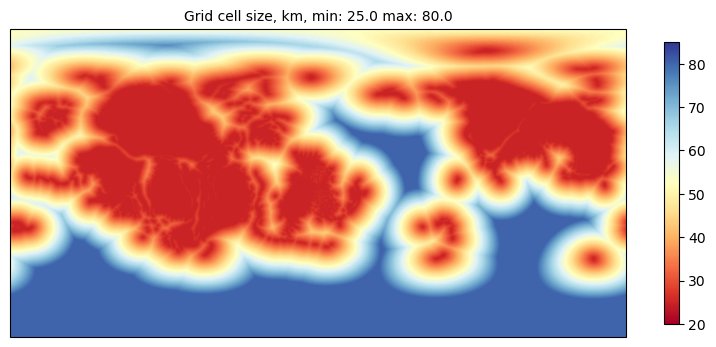

In [4]:
vtkMesh = ufcts.generateVTKmesh(ucoords, ufaces)
dcoast = ufcts.distanceCoasts(vtkMesh, ucoords, dual_mesh.h.values, reso_contour)
ngrd = ufcts.getGridCoast(ncgrid, dual_mesh, dcoast, input_path)
ds, cellWidth = ufcts.cellWidthVsLatLonFuncDist(ngrd, width=[highres,lowres], maxdist=2.5e6)

plotWeight = True
if plotWeight:
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=[8.0, 5.0])
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    im = ax.imshow(cellWidth, origin='lower',
                   vmin=cellWidth.min()-5,
                   vmax=cellWidth.max()+5,
                    transform=ccrs.PlateCarree(),
                    extent=[-180, 180, -90, 90], cmap='RdYlBu',
                    zorder=0)
    plt.title(
        'Grid cell size, km, min: {:.1f} max: {:.1f}'.format(
            cellWidth.min(),cellWidth.max()),fontsize=10)
    plt.colorbar(im, shrink=.60)
    fig.canvas.draw()
    plt.tight_layout()
    # plt.savefig(input_path+'/cellWidthGlobal.png', bbox_inches='tight')
    plt.show()
    plt.close()

We will now use this variable width array to generate our mesh.

In [5]:
# Build the mesh
lon = ncgrid.lon.values
lat = ncgrid.lat.values
ufcts.refineGlobalMesh(cellWidth, lon, lat, input_path)

Step 1. Generate mesh with JIGSAW
Running: jigsaw mesh.jig
 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation library.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.14

  Reading CFG. file...

  CFG. data summary...

  GEOM-FILE = mesh.msh 
  MESH-FILE = mesh-MESH.msh 
  HFUN-FILE = mesh-HFUN.msh 
  INIT-FILE =  
  TRIA-FILE =  
  BNDS-FILE =  

  GEOM-SEED = 8 
  GEOM-PHI1 = 6.00e+01 
  GEOM-PHI2 = 6.00e+01 
  GEOM-ETA1 = 4.50e+01 
  GEOM-ETA2 = 4.50e+01 
  GEOM-FEAT = F

This will generate a new mesh called `mesh_refine.nc` over which we are going to interpolate our goSPL variable (elevation and rainfall). 

In [7]:
# Loading the UGRID file
ufile = input_path+'/mesh_refine.nc'
ugrid = uxr.open_grid(ufile) 

# Perform the interpolation (bilinear) 
var_path = 'vars_'+str(highres)+"_"+str(lowres)
var_name = 'refine_250'
ufcts.inter2UGRID(ncgrid,ugrid,var_path,var_name,type='face')
data_file = [var_path+'/'+var_name+'.nc']

# Get the information related to the mesh: primal and dual mesh
primal_mesh = uxr.open_dataset(ufile, *data_file, use_dual=False)
dual_mesh = uxr.open_dataset(ufile, *data_file, use_dual=True)

# Extract nodes and faces information
ucoords = np.empty((dual_mesh.uxgrid.n_node,3))
ucoords[:,0] = dual_mesh.uxgrid.node_x.values
ucoords[:,1] = dual_mesh.uxgrid.node_y.values
ucoords[:,2] = dual_mesh.uxgrid.node_z.values
ufaces = primal_mesh.uxgrid.node_face_connectivity.values

# Get information about your mesh:
print("Number of nodes: ",len(ucoords)," | number of faces ",len(ufaces))
edge_min = np.round(dual_mesh.uxgrid.edge_node_distances.min().values/1000.+0.,2)
edge_max = np.round(dual_mesh.uxgrid.edge_node_distances.max().values/1000.+0.,2)
edge_mean = np.round(dual_mesh.uxgrid.edge_node_distances.mean().values/1000.+0.,2)
print("edge range (km): min ",edge_min," | max ",edge_max," | mean ",edge_mean)

Number of nodes:  471704  | number of faces  943404
edge range (km): min  5.66  | max  71.32  | mean  19.04


In [8]:
# Save voronoi mesh for visualisation purposes
saveVoro = True

if saveVoro:
    from mpas_tools.viz.paraview_extractor import extract_vtk
    extract_vtk(
            filename_pattern=ufile,
            variable_list='areaCell',
            dimension_list=['maxEdges=','nVertLevels=', 'nParticles='], 
            mesh_filename=ufile,
            out_dir=input_path, 
            ignore_time=True,
            # lonlat=True,
            xtime='none'
        )
    print("You could now visualise in Paraview (wireframe) the produced voronoi mesh!")
    print("This is a vtp mesh called: ", input_path+'/staticFieldsOnCells.vtp')

Build time indices:   0% |                                     | ETA:  --:--:--
Build time indices: 100% |#####################################| Time:  0:00:00
Writing time series:   0% |                                    | ETA:  --:--:--


maxEdges=
nVertLevels=
nParticles=

Extracting a total of 1 time levels.
Using file 'input_25_80/mesh_refine.nc' as the mesh file for this extraction.


The following variables will be extracted from the input file(s).

   Variables with 'nCells' as a dimension:
      name: areaCell

 -- Extracting cell fields --
Build geometry for fields on cells...


Writing time series:   0% |                                    | ETA:  --:--:--
Writing time series: 100% |####################################| Time:  0:00:01



You could now visualise in Paraview (wireframe) the produced voronoi mesh!
This is a vtp mesh called:  input_25_80/staticFieldsOnCells.vtp


## goSPL mesh input

In [9]:
meshname = var_path+"/mesh"
np.savez_compressed(meshname, v=ucoords, c=ufaces, 
                    z=dual_mesh.h.data
                    )

forcname = var_path+"/rain250"
np.savez_compressed(forcname, 
                    r=dual_mesh.rain.data,
                    )